モデルの均衡条件は以下で与えられる

\begin{align*}
    y_{t} &= E_{t}y_{t+1} - (R_{t}-E_{t}\pi_{t+1}-s_{t}),\\
    \pi_{t} &= \beta E_{t}\pi_{t+1} + \kappa y_{t},\\
    R_{t}^{*} &= r^{*} + \phi_{\pi} E_{t}\pi_{t+1},\\
    R_{t} &= \max \{R_{t}^{*} ,0\}.
\end{align*}

$(\beta,\kappa,\phi_{\pi},r^{*})$はモデルのパラメータ。定常状態での政策金利は、$r^{*}=(\beta^{-1}-1) \times 100$

$s_t\in\{s_{H},s_{L}\}$は以下の遷移行列を持つマルコフ連鎖にしたがう
\begin{align*}
    P = \left[\begin{array}{cc}
    1-p_{H} & p_{H}\\
    1-p_{L} & p_{L}
    \end{array}\right].
\end{align*}


In [1]:
struct Model
    β::Float64           # 割引因子
    κ::Float64           # フィリップス曲線の傾き
    ϕ::Float64           # テイラー係数
    rstar::Float64       # pH=0のときの、定常状態での名目金利の値
    sH::Float64          # 状態Hでの自然利子率の値
    sL::Float64          # 状態Lでの自然利子率の値
    pH::Float64          # 危機の発生確率
    pL::Float64          # 危機の継続確率
    Gs::Array{Float64,1} # 状態変数のグリッド
    Ps::Array{Float64,2} # 状態変数の遷移確率
    maxiter::Int64       # 繰り返し回数の最大値
    tol::Float64         # 許容誤差
end

### 解析的解

- ここで、

\begin{align*}
  \mathbb{E}_{t}y_{t+1} &= (1-p_{i})y_{H} + p_{i}y_{L} \\
  \mathbb{E}_{t}\pi_{t+1} &= (1-p_{i})\pi_{H} + p_{i}\pi_{L}
\end{align*}

をそれぞれの状態$i\in\{H,L\}$における均衡条件に代入すると、

\begin{align*}
  y_{H} &= (1-p_{H})y_{H} + p_{H}y_{L} - \left(R_{H}-[(1-p_{H})\pi_{H} + p_{H}\pi_{L}]-s_{H}\right) \\
  \pi_{H} &= \kappa y_{H} + \beta [(1-p_{H})\pi_{H} + p_{H}\pi_{L}] \\
  R_{H} &= r^{*} + \phi_{\pi} [(1-p_{H})\pi_{H} + p_{H}\pi_{L}] \\
  y_{L} &= (1-p_{L})y_{H} + p_{L}y_{L} - \left(0-[(1-p_{L})\pi_{H} + p_{L}\pi_{L}]-s_{L}\right) \\
  \pi_{L} &= \kappa y_{L} + \beta [(1-p_{L})\pi_{H} + p_{L}\pi_{L}] \\
  R_{L} &= 0  
\end{align*}

6つの未知数に対して6つの線形の方程式があるため、未知数を解析的に求めることができる

### 時間反復法による数値解

- $N_{s}$が大きい場合は解析解を求めるのが非常に煩雑になるため、このアプローチが有用

### アルゴリズム

#### 1. グリッド生成
状態空間の評価点を有限個のグリッドに区切る。この場合、$\{s_{H},s_{L}\}$はすでに与えられている

#### 2. 収束の基準
収束の基準になるパラメータ$\varepsilon>0$を与える

#### 3. 最適化
古い政策関数

$$
\color{blue}{\varsigma_{y}^{(n-1)}(s_{i})}, \quad \color{blue}{\varsigma_{\pi}^{(n-1)}(s_{i})}
$$

およびグリッドにおける$\color{blue}{s_{i}}$の値を所与として、以下の式を$(\color{magenta}{y_{i}^{(n)},\pi_{i}^{(n)},R_{i}^{(n)}})$について解く

\begin{align*}
  \color{magenta}{y_{i}^{(n)}} &= \color{blue}{y_{i}^{e}} - \left(\color{magenta}{R_{i}^{(n)}}-\color{blue}{\pi_{i}^{e}}-\color{blue}{s_{i}}\right) \\
  \color{magenta}{\pi_{i}^{(n)}} &= \kappa \color{magenta}{y_{i}^{(n)}} + \beta \color{blue}{\pi_{i}^{e}} \\
  \color{magenta}{R_{i}^{(n)}} &= \max\{r^{*} + \phi_{\pi} \color{blue}{\pi_{i}^{e}}, 0\}
\end{align*}

ここで、

\begin{align*}
  \color{blue}{y_{i}^{e}} &= (1-p_{i})\color{blue}{\varsigma_{y}^{(n-1)}(s_{H})} + p_{i}\color{blue}{\varsigma_{y}^{(n-1)}(s_{L})} \\
  \color{blue}{\pi_{i}^{e}} &= (1-p_{i})\color{blue}{\varsigma_{\pi}^{(n-1)}(s_{H})} + p_{i}\color{blue}{\varsigma_{\pi}^{(n-1)}(s_{L})}
\end{align*}

であり、期待値は古い政策関数から求められる

このステップで、それぞれのグリッド上の政策関数の値、すなわち新しい政策関数

\begin{align*}
\varsigma^{(n)}(s_{i}) &= (\varsigma_{y}^{(n)}(s_{i}),\varsigma_{\pi}^{(n)}(s_{i}),\varsigma_{R}^{(n)}(s_{i})) \\
 &= ((y_{H}^{(n)},y_{L}^{(n)}),(\pi_{H}^{(n)},\pi_{L}^{(n)}),(R_{H}^{(n)},R_{L}^{(n)}))
\end{align*}

を得る

#### 4. 収束の判定
全ての$s_{i}$について$\|\varsigma^{(n)}(s_{i})-\varsigma^{(n-1)}(s_{i})\|<\varepsilon$であればストップ。そうでなければ、$\varsigma^{(n)}(s_{i})$を$\varsigma^{(n-1)}(s_{i})$に代入して、ステップ3-4を繰り返す

In [2]:
# time iterationを行う関数
function ti(m)

    β = m.β
    κ = m.κ
    ϕ = m.ϕ
    rstar = m.rstar
    sH = m.sH
    sL = m.sL
    pH = m.pH
    pL = m.pL
    
#     ## STEP 1.a: グリッド生成
#     Gs = [sH; sL]
#     Ps = [1.0-pH pH; 
#         1.0-pL pL]
    Gs = m.Gs
    Ps = m.Ps
    
    # 解析的解
    A = [-1+(1-pH) pH -(ϕ-1)*(1-pH) -(ϕ-1)*pH;
    κ 0 -1+β*(1-pH) β*pH;
    (1-pL) -1+pL (1-pL) pL;
    0 κ β*(1-pL) -1+β*pL]
    b = [rstar-sH;0;-sL;0]
    x = A\b
    yH  = x[1]
    yL  = x[2]
    piH = x[3]
    piL = x[4]
    rH = rstar + ϕ*((1-pH)*piH + pH*piL)

    ## STEP 1.b: 政策関数の初期値を当て推量
    Ns = 2
    # 解析的解を初期値とする(1回の繰り返しで収束)
    yvec0 = [yH; yL]
    pvec0 = [piH; piL]
    rvec0 = [rH; 0]
    # 適当な初期値
    #yvec0 = zeros(Ns)
    #pvec0 = zeros(Ns)
    #rvec0 = zeros(Ns)
    
    yvec1 = zeros(Ns)
    pvec1 = zeros(Ns)
    rvec1 = zeros(Ns)
    
    ## STEP 4: 政策関数を繰り返し計算
    diff = 1e+4
    iter = 1

    while(diff > m.tol && iter < m.maxiter)

        ## STEP 3: 各グリッドごとに最適化
        for is = 1:Ns

            # ショックの値
            s0 = Gs[is]

            # 古い政策関数から期待値(ye,pie)を計算
            ye = Ps[is,1]*yvec0[1] + Ps[is,2]*yvec0[2]
            pie = Ps[is,1]*pvec0[1] + Ps[is,2]*pvec0[2]

            # 期待値を所与として(y0,pi0,r0)を計算
            r0 = max(rstar + ϕ*pie, 0)
            y0 = ye - (r0 - pie - s0)
            pi0 = κ*y0 + β*pie

            # 新しい政策関数を保存
            yvec1[is] = y0
            pvec1[is] = pi0
            rvec1[is] = r0

        end
        
        # 繰り返し計算誤差を確認
        ydiff = maximum(abs.(yvec1-yvec0))
        pdiff = maximum(abs.(pvec1-pvec0))
        rdiff = maximum(abs.(rvec1-rvec0))
        diff = maximum([ydiff pdiff rdiff])

        println([iter diff])

        # 政策関数をアップデート
        # 注意：Juliaで配列の代入はポインタ渡し
        yvec0 = copy(yvec1)
        pvec0 = copy(pvec1)
        rvec0 = copy(rvec1)
        
        iter = iter + 1

    end
    
    return yvec0, pvec0, rvec0
    
end

ti (generic function with 1 method)

### メインファイル
$(\kappa,s_L)$の値は、$p_H=0$のときに、危機における産出ギャップとインフレ率の値が、$(y_L,\pi_L)=(-7.0,-1.0/4)$となるように設定（カリブレーション）

異なる$(\kappa,s_L)$の値の下で、解析解を用いて、$(y_L,\pi_L)$を計算

In [3]:
# カリブレーションに用いる関数
function dist(x0,β,ϕ,rstar,sH,pH,pL,yLtar,piLtar)

    sL = x0[1]
    κ = x0[2]

    # 解析的解
    A = [-1+(1-pH) pH -(ϕ-1)*(1-pH) -(ϕ-1)*pH;
    κ 0 -1+β*(1-pH) β*pH;
    (1-pL) -1+pL (1-pL) pL;
    0 κ β*(1-pL) -1+β*pL]
    b = [rstar-sH;0;-sL;0]
    x = A\b
    yH  = x[1]
    yL  = x[2]
    piH = x[3]
    piL = x[4]
    rH = rstar + ϕ*((1-pH)*piH + pH*piL)

    # データの値とモデルの値の間の距離を最小化
    f = (yL-yLtar)^2 + (piL-piLtar)^2

    return f
    
end

dist (generic function with 1 method)

In [4]:
# ライブラリの読み込み
using Optim # 最適化関数（カリブレーションに使用）
using Plots # グラフのプロット

# Juliaにおいて、関数の外に書かれる変数はすべてグローバル変数（関数の中からもアクセスできる）

rstar = 0.75 # pH=0のときの、定常状態での名目金利の値
β = 1/(1+rstar/100) # 割引率(オイラー方程式の定常状態より)
ϕ = 5.0  # テイラー係数(注: 小さいとiL=0にならない)
pL = 0.75  # 危機の継続確率
sH = rstar # 状態Hでの自然利子率の値

# カリブレーション
# yLとpiLのターゲットにpH=0のときのモデルの値を合わせるように、sLとkapの値をセット

pH = 0.0 # 危機が起こる確率
x0 = [-2.0, 0.01] # sLとkapの初期値

# yLとpiLのターゲット
yLtar = -7.0
piLtar = -1.0/4

# 最小化関数(Juliaの場合NelderMead())を用いる
dist!(x0) = dist(x0,β,ϕ,rstar,sH,pH,pL,yLtar,piLtar)
res = optimize(dist!,x0,NelderMead())

# カリブレートしたパラメータをセット
sL = res.minimizer[1]  # 状態Lでの自然利子率の値
κ = res.minimizer[2] # フィリップス曲線の傾き
println([κ sL])

maxiter = 2000 # 繰り返し回数の最大値
tol = 1e-5 # 許容誤差

[0.00912668190392673 -1.5625167241936313]


1.0e-5

$p_H \in \{0,0.025\}$のそれぞれのケースで数値解を計算

In [5]:
pH = 0.0

## STEP 1.a: グリッド生成
Gs = [sH; sL]
Ps = [1.0-pH pH; 
    1.0-pL pL]

# 構造体にパラメータを格納
m = Model(β,κ,ϕ,rstar,sH,sL,pH,pL,Gs,Ps,maxiter,tol)
@time yvec0, pvec0, rvec0 = ti(m)

[1.0 2.7755575615628914e-17]
  0.294368 seconds (412.30 k allocations: 21.696 MiB, 8.18% gc time)


([-8.881784197001252e-16, -6.999956498203862], [-8.106121910535373e-18, -0.24996320047644555], [0.75, 0.0])

In [6]:
pH = 0.025

## STEP 1.a: グリッド生成
Gs = [sH; sL]
Ps = [1.0-pH pH; 
    1.0-pL pL]

# 構造体にパラメータを格納
m = Model(β,κ,ϕ,rstar,sH,sL,pH,pL,Gs,Ps,maxiter,tol)
@time yvec1, pvec1, rvec1 = ti(m)

[1.0 8.881784197001252e-16]
  0.000095 seconds (181 allocations: 8.531 KiB)


([0.5966221205094636, -6.500827012098151], [-0.03858366046226398, -0.26959952512360896], [0.528204714606012, 0.0])

### 結果のプロット

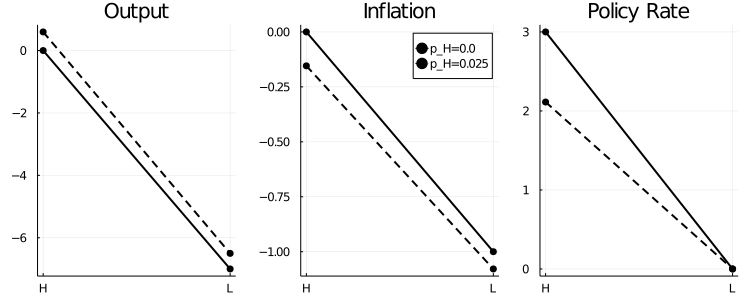

In [7]:
x1 = [1 2; 1 2]
x2 = x1
x3 = x1
y1 = [rvec0'*4; rvec1'*4]
y2 = [yvec0'; yvec1']
y3 = [pvec0'*4; pvec1'*4]
cl = [:black :black]
ls = [:solid :dash]

plot(
    plot(x2',y2',title="Output",color=cl,linestyle=ls,legend=false), #,markershape=msh,markersize=msz),
    plot(x3',y3',title="Inflation",color=cl,linestyle=ls,legend=:best,label=["p_H=0.0" "p_H=0.025"]), #,linewidth=lw,color=cl,markershape=msh,markersize=msz),
    plot(x1',y1',title="Policy Rate",color=cl,linestyle=ls,legend=false), #,markershape=msh,markersize=msz),
    layout=(1,3),size=(750,300),linewidth=2,markershape=:circle,markersize=4,xticks=([1 2],["H" "L"])
)